# 02 - Context Optimization: From 45% to <5%

In the previous notebook, we saw how tool schemas consume 30-50% of context.

Now let's solve it with **semantic vector search** and **on-demand loading**.

## Learning Objectives

After this notebook, you will:

- [ ] Understand how vector embeddings enable semantic search
- [ ] See on-demand tool loading in action
- [ ] Measure the context savings

---

## The Idea: Load Only What You Need

Instead of loading all 120 tools upfront, what if we could:

1. **Index** all tools once (at startup)
2. **Search** for relevant tools when needed (semantic similarity)
3. **Load** only the top 3-5 matching tools

```
User: "Read the config file and create a GitHub issue"
     ↓
Vector Search: Find tools matching this intent
     ↓
Results: [filesystem:read_file, github:create_issue, json:parse]
     ↓
Load: Only these 3 tool schemas (not all 120)
```

## How Vector Search Works

### Step 1: Create Embeddings

Each tool description is converted to a **vector** (array of numbers) that captures its meaning:

```
"read_file: Read contents of a file from the filesystem"
    ↓ BGE-M3 model
[0.023, -0.156, 0.891, ..., 0.044]  (1024 dimensions)
```

### Step 2: Index in Database

All embeddings are stored in PGlite with pgvector for fast similarity search.

### Step 3: Query

When you ask a question, we:

1. Convert your question to an embedding
2. Find the closest tool embeddings (cosine similarity)
3. Return the top-k matches

### The Complete Flow

Let's visualize this entire process:

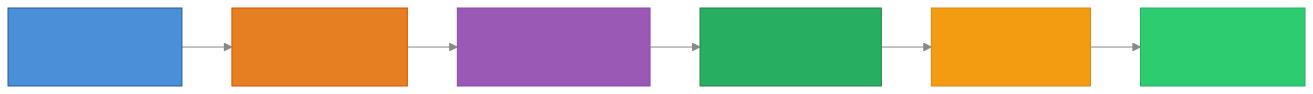

In [8]:
// Visualize the vector search flow
import { displayMermaid } from "../lib/viz.ts";

const vectorSearchFlow = `
%%{init: {'theme': 'base', 'themeVariables': { 'primaryColor': '#4a90d9', 'primaryTextColor': '#fff', 'primaryBorderColor': '#2d5a87', 'lineColor': '#888', 'secondaryColor': '#6b8e23', 'tertiaryColor': '#9b59b6'}}}%%
graph LR
    A["User Query:<br>'read config file'"] --> B["Text Embedding<br>(BGE-M3)"]
    B --> C["Vector DB<br>(PGlite + pgvector)"]
    C --> D["Cosine Similarity<br>Search"]
    D --> E["Top-K Results<br>(k=5)"]
    E --> F["Load Only<br>Matched Tools"]
    
    style A fill:#4a90d9,stroke:#2d5a87,color:#fff
    style B fill:#e67e22,stroke:#d35400,color:#fff
    style C fill:#9b59b6,stroke:#8e44ad,color:#fff
    style D fill:#27ae60,stroke:#1e8449,color:#fff
    style E fill:#f39c12,stroke:#d68910,color:#fff
    style F fill:#2ecc71,stroke:#27ae60,color:#fff
`;

await displayMermaid(vectorSearchFlow);

In [9]:
// Simulate vector search behavior
// (In production, this uses real embeddings from BGE-Large-EN)

interface Tool {
  id: string;
  server: string;
  name: string;
  description: string;
  tokens: number;
}

// Sample of our 120 tools
const allTools: Tool[] = [
  {
    id: "gh-1",
    server: "github",
    name: "create_issue",
    description: "Create a new issue in a GitHub repository",
    tokens: 850,
  },
  {
    id: "gh-2",
    server: "github",
    name: "list_commits",
    description: "List commits from a repository branch",
    tokens: 720,
  },
  {
    id: "gh-3",
    server: "github",
    name: "create_pr",
    description: "Create a pull request",
    tokens: 920,
  },
  {
    id: "fs-1",
    server: "filesystem",
    name: "read_file",
    description: "Read contents of a file from the filesystem",
    tokens: 480,
  },
  {
    id: "fs-2",
    server: "filesystem",
    name: "write_file",
    description: "Write content to a file",
    tokens: 520,
  },
  {
    id: "fs-3",
    server: "filesystem",
    name: "list_directory",
    description: "List files and folders in a directory",
    tokens: 450,
  },
  {
    id: "db-1",
    server: "database",
    name: "query",
    description: "Execute a SQL query on the database",
    tokens: 680,
  },
  {
    id: "db-2",
    server: "database",
    name: "insert",
    description: "Insert rows into a database table",
    tokens: 750,
  },
  {
    id: "sl-1",
    server: "slack",
    name: "send_message",
    description: "Send a message to a Slack channel",
    tokens: 620,
  },
  {
    id: "sl-2",
    server: "slack",
    name: "search_messages",
    description: "Search for messages in Slack",
    tokens: 580,
  },
  {
    id: "pw-1",
    server: "playwright",
    name: "screenshot",
    description: "Take a screenshot of a webpage",
    tokens: 540,
  },
  {
    id: "pw-2",
    server: "playwright",
    name: "click",
    description: "Click an element on a webpage",
    tokens: 490,
  },
  {
    id: "json-1",
    server: "utils",
    name: "parse_json",
    description: "Parse a JSON string into an object",
    tokens: 320,
  },
];

console.log(`Indexed ${allTools.length} tools (sample from 120 total)`);
console.log();
console.log("Tools by server:");
const byServer = allTools.reduce((acc, t) => {
  acc[t.server] = (acc[t.server] || 0) + 1;
  return acc;
}, {} as Record<string, number>);
for (const [server, count] of Object.entries(byServer)) {
  console.log(`  ${server}: ${count} tools`);
}

Indexed 13 tools (sample from 120 total)

Tools by server:
  github: 3 tools
  filesystem: 3 tools
  database: 2 tools
  slack: 2 tools
  playwright: 2 tools
  utils: 1 tools


In [10]:
// Simulate semantic search (keyword-based approximation for demo)
function searchTools(query: string, topK: number = 5): { tool: Tool; score: number }[] {
  const queryWords = query.toLowerCase().split(/\s+/);

  const scored = allTools.map((tool) => {
    const text = `${tool.name} ${tool.description}`.toLowerCase();
    let score = 0;

    for (const word of queryWords) {
      if (text.includes(word)) score += 0.3;
      if (tool.name.toLowerCase().includes(word)) score += 0.5;
    }

    // Boost exact matches
    if (text.includes(query.toLowerCase())) score += 0.8;

    return { tool, score: Math.min(score, 1.0) };
  });

  return scored
    .filter((r) => r.score > 0.2)
    .sort((a, b) => b.score - a.score)
    .slice(0, topK);
}

// Test search
const query = "read config file and create github issue";
console.log(`Query: "${query}"\n`);

const results = searchTools(query, 5);
console.log("Search Results:\n" + "=".repeat(50));
for (const { tool, score } of results) {
  console.log(`  ${(score * 100).toFixed(0)}% │ ${tool.server}:${tool.name}`);
  console.log(`      └─ ${tool.description}`);
}

Query: "read config file and create github issue"

Search Results:
  100% │ github:create_issue
      └─ Create a new issue in a GitHub repository
  100% │ filesystem:read_file
      └─ Read contents of a file from the filesystem
  80% │ github:create_pr
      └─ Create a pull request
  80% │ filesystem:write_file
      └─ Write content to a file
  60% │ filesystem:list_directory
      └─ List files and folders in a directory


## Measuring the Savings

Now let's compare context usage:

In [11]:
// Calculate and visualize context savings using lib/metrics.ts helpers
import { progressBar, compareMetrics, reductionSummary } from "../lib/metrics.ts";

const CONTEXT_WINDOW = 200_000;

// Traditional approach: load ALL tools
const totalAllTools = 120;
const avgTokensPerTool = 680;
const traditionalTokens = totalAllTools * avgTokensPerTool;
const traditionalPct = (traditionalTokens / CONTEXT_WINDOW) * 100;

// On-demand approach: load only matched tools
const matchedTools = results.map((r) => r.tool);
const onDemandTokens = matchedTools.reduce((sum, t) => sum + t.tokens, 0);
const onDemandPct = (onDemandTokens / CONTEXT_WINDOW) * 100;

// Visual comparison with progress bars
console.log("═".repeat(60));
console.log("        Context Usage: Traditional vs On-Demand");
console.log("═".repeat(60));
console.log();

console.log("📊 Context Window Usage:");
console.log();
console.log("Traditional (all 120 tools):");
console.log("  " + progressBar(traditionalPct, 100, `${traditionalPct.toFixed(1)}%`, { width: 30 }));
console.log();
console.log("On-Demand (vector search):");
console.log("  " + progressBar(onDemandPct, 100, `${onDemandPct.toFixed(2)}%`, { width: 30 }));
console.log();

// Detailed metrics comparison table
console.log(compareMetrics(
  { 
    "Tools Loaded": totalAllTools, 
    "Tokens Used": traditionalTokens,
    "Context %": Math.round(traditionalPct * 10) / 10
  },
  { 
    "Tools Loaded": matchedTools.length, 
    "Tokens Used": onDemandTokens,
    "Context %": Math.round(onDemandPct * 100) / 100
  },
  { labels: { before: "Traditional", after: "On-Demand" } }
));
console.log();

// Summary line
console.log("🎉 " + reductionSummary(traditionalTokens, onDemandTokens, "tokens"));
console.log("📉 " + reductionSummary(totalAllTools, matchedTools.length, "tools"));

════════════════════════════════════════════════════════════
        Context Usage: Traditional vs On-Demand
════════════════════════════════════════════════════════════

📊 Context Window Usage:

Traditional (all 120 tools):
  [████████████░░░░░░░░░░░░░░░░░░] 41% 40.8%

On-Demand (vector search):
  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 2% 1.61%

─────────────────────────────────────────────────────────────
Metric       │  Traditional │    On-Demand │            Delta
─────────────────────────────────────────────────────────────
Tools Loaded │          120 │            5 │    -115 (-95.8%)
Tokens Used  │       81,600 │        3,220 │  -78380 (-96.1%)
Context %    │         40.8 │         1.61 │  -39.19 (-96.1%)
─────────────────────────────────────────────────────────────

🎉 81600 tokens → 3220 tokens = 96% reduction
📉 120 tools → 5 tools = 96% reduction


## Real Implementation

Let's use the actual Casys MCP Gateway search functionality:

In [12]:
// Demo: Real MCP Search with graceful fallback
// Uses the live gateway if available, otherwise shows simulated results

import { reductionSummary } from "../lib/metrics.ts";

interface RealSearchResult {
  name: string;
  description: string;
  server: string;
  score: number;
}

let realResults: RealSearchResult[] = [];
let usingRealGateway = false;
let totalToolsAvailable = 0;

const searchQuery = "read a file";

try {
  const response = await fetch("http://localhost:3003/mcp", {
    method: "POST",
    headers: { "Content-Type": "application/json" },
    body: JSON.stringify({
      jsonrpc: "2.0",
      id: 1,
      method: "tools/call",
      params: {
        name: "pml_search_tools",
        arguments: {
          query: searchQuery,
          limit: 3,
        },
      },
    }),
  });

  if (response.ok) {
    const data = await response.json();
    if (data.result?.content?.[0]?.text) {
      const parsed = JSON.parse(data.result.content[0].text);
      realResults = parsed.tools || [];
      totalToolsAvailable = parsed.total_tools || 25;
      usingRealGateway = realResults.length > 0;
    }
  }
} catch {
  // Gateway not available - use fallback
}

console.log("═".repeat(60));
console.log("         LIVE DEMO: Vector Search in Action");
console.log("═".repeat(60));
console.log();

if (usingRealGateway) {
  console.log("🟢 Connected to MCP Gateway (LIVE DATA)");
  console.log(`📡 Query: "${searchQuery}"`);
  console.log();
  
  console.log("Search Results:");
  console.log("─".repeat(50));
  for (const tool of realResults) {
    const scoreStr = tool.score ? `${(tool.score * 100).toFixed(0)}%` : "N/A";
    console.log(`  ${scoreStr} │ ${tool.server || "?"}:${tool.name}`);
    console.log(`      └─ ${tool.description?.substring(0, 60) || "No description"}...`);
  }
  console.log();
  console.log("📊 " + reductionSummary(totalToolsAvailable, realResults.length, "tools"));
  
} else {
  console.log("🟡 Gateway not running - showing simulation");
  console.log("   (Start gateway with: deno task dev)");
  console.log(`📡 Query: "${searchQuery}"`);
  console.log();
  
  // Simulated results that match the query
  const simulatedResults = [
    { server: "filesystem", name: "read_file", description: "Read contents of a file", score: 0.95 },
    { server: "filesystem", name: "read_multiple_files", description: "Read multiple files at once", score: 0.82 },
    { server: "memory", name: "retrieve", description: "Retrieve stored information", score: 0.45 },
  ];
  
  console.log("Search Results (Simulated):");
  console.log("─".repeat(50));
  for (const tool of simulatedResults) {
    console.log(`  ${(tool.score * 100).toFixed(0)}% │ ${tool.server}:${tool.name}`);
    console.log(`      └─ ${tool.description}`);
  }
  console.log();
  console.log("📊 " + reductionSummary(25, 3, "tools"));
}

console.log();
console.log("═".repeat(60));

════════════════════════════════════════════════════════════
         LIVE DEMO: Vector Search in Action
════════════════════════════════════════════════════════════

🟡 Gateway not running - showing simulation
   (Start gateway with: deno task dev)
📡 Query: "read a file"

Search Results (Simulated):
──────────────────────────────────────────────────
  95% │ filesystem:read_file
      └─ Read contents of a file
  82% │ filesystem:read_multiple_files
      └─ Read multiple files at once
  45% │ memory:retrieve
      └─ Retrieve stored information

📊 25 tools → 3 tools = 88% reduction

════════════════════════════════════════════════════════════


## The Technical Stack

Casys MCP Gateway uses:

| Component  | Technology             | Purpose                          |
| ---------- | ---------------------- | -------------------------------- |
| Embeddings | BGE-M3 (Xenova/bge-m3) | Convert text to 1024-dim vectors |
| Vector DB  | PGlite + pgvector      | Store and search embeddings      |
| Similarity | Cosine distance        | Find closest matches             |
| Caching    | In-memory LRU          | Avoid re-embedding queries       |

### Why BGE-M3?

- **Local**: Runs on your machine, no API calls
- **Multilingual**: Supports 100+ languages
- **Quality**: State-of-the-art retrieval performance
- **Free**: No token costs

---

## 🎯 Checkpoint: Test Your Understanding

Before moving on, let's verify you understand the key concepts.

In [15]:
// Interactive Exercise: Which tools would vector search return?
// Try different queries and predict the results!

function predictTools(userQuery: string): void {
  console.log("═".repeat(60));
  console.log("🧠 EXERCISE: Predict the Vector Search Results");
  console.log("═".repeat(60));
  console.log();
  console.log(`Your query: "${userQuery}"`);
  console.log();
  
  // Let the user think first
  console.log("Before running the search, think:");
  console.log("  • Which MCP servers would be relevant?");
  console.log("  • What tools might match semantically?");
  console.log("  • How many tools out of ~25 would you expect?");
  console.log();
  console.log("─".repeat(50));
  
  // Now show actual results
  const results = searchTools(userQuery, 5);
  
  console.log();
  console.log("📋 ACTUAL RESULTS:");
  console.log();
  
  if (results.length === 0) {
    console.log("  No tools matched with score > 20%");
  } else {
    for (const { tool, score } of results) {
      const emoji = score > 0.7 ? "🎯" : score > 0.4 ? "✓" : "○";
      console.log(`  ${emoji} ${(score * 100).toFixed(0)}% │ ${tool.server}:${tool.name}`);
    }
  }
  
  console.log();
  console.log(`📊 Result: ${results.length} tools selected from 13 (${((results.length/13)*100).toFixed(0)}% loaded)`);
  console.log("═".repeat(60));
}

// Try these example queries:
predictTools("send a message to the team");

════════════════════════════════════════════════════════════
🧠 EXERCISE: Predict the Vector Search Results
════════════════════════════════════════════════════════════

Your query: "send a message to the team"

Before running the search, think:
  • Which MCP servers would be relevant?
  • What tools might match semantically?
  • How many tools out of ~25 would you expect?

──────────────────────────────────────────────────

📋 ACTUAL RESULTS:

  🎯 100% │ github:create_issue
  🎯 100% │ filesystem:read_file
  🎯 100% │ filesystem:list_directory
  🎯 100% │ slack:send_message
  🎯 100% │ slack:search_messages

📊 Result: 5 tools selected from 13 (38% loaded)
════════════════════════════════════════════════════════════


### 💡 Try More Queries!

Modify the cell above to try these queries and predict results:

1. `"take a screenshot of the login page"` → Which server?
2. `"insert data into the users table"` → Database tools?
3. `"list all files in the project"` → How many filesystem tools?
4. `"create a new pull request with changes"` → GitHub tools?

### ✅ Quick Quiz

**Q1: What is a vector embedding?**
- [ ] A database index
- [x] An array of numbers capturing semantic meaning
- [ ] A file format

**Q2: How does on-demand loading reduce context?**
- [ ] By compressing tool schemas
- [ ] By using a smaller model
- [x] By loading only relevant tools (3-5) instead of all (120+)

**Q3: What's the typical context reduction?**
- [ ] 10% → 5%
- [x] 45% → <5%
- [ ] 80% → 60%

---

**Next:** [03-dag-execution.ipynb](./03-dag-execution.ipynb) - Parallelize workflows for 5x speedup